In [12]:
from transformers import pipeline
import pandas as pd
import numpy as np
from pymongo import MongoClient

def load_sentiment_model(model_path: str) -> pipeline:
    """加载情绪分析模型"""
    return pipeline(
        "text-classification",
        model=model_path,
        tokenizer=model_path,
        return_all_scores=False,
        truncation=True,
        max_length=512,
        device=0  # 自动使用GPU
    )

In [6]:
def parse_view(view_str):
    """将股吧浏览量字符串转为整数"""
    if not view_str or view_str == '0':
        return 0

    view_str = str(view_str).strip()

    if '万' in view_str:
        try:
            num = float(view_str.replace('万', ''))
            return int(num * 10000)
        except ValueError:
            return 0

    try:
        return int(view_str)
    except ValueError:
        return 0

In [3]:
def map_to_financial_sentiment(label: str) -> str:
    """将模型标签映射到金融情绪"""
    positive_labels = {"like", "happiness", "surprise"}  # 看多/乐观
    negative_labels = {"anger", "disgust", "fear", "sadness"}  # 看空/悲观
    neutral_labels = {"none"}  # 中性

    if label in positive_labels:
        return "Positive"
    elif label in negative_labels:
        return "Negative"
    else:
        return "Neutral"

In [4]:
def sentiment_to_score(sentiment_str: str) -> int:
    """将金融情绪转为数值分数"""
    if sentiment_str == "Positive":
        return 1
    elif sentiment_str == "Neutral":
        return 0
    else:
        return -1

In [10]:
def extract_and_preprocess_data(collection_name: str) -> pd.DataFrame:
    """从MongoDB提取并清洗股吧数据"""
    # 连接MongoDB
    client = MongoClient('localhost', 27017)
    collection = client['post_info'][collection_name]

    # 数据提取与清洗
    data_list = []
    for doc in collection.find({}, {'_id': 0, 'post_title': 1, 'post_view': 1, 'post_date': 1, 'comment_num': 1}):
        # 浏览量转换
        view = parse_view(doc.get('post_view', '0'))
        # 评论数转换
        comment_num = int(doc.get('comment_num', '0')) if str(doc.get('comment_num', '')).isdigit() else 0

        data_list.append({
            'title': doc.get('post_title', ''),
            'view': view,
            'date': doc.get('post_date', ''),
            'comment_num': comment_num
        })

    # 转换为DataFrame并处理日期
    df = pd.DataFrame(data_list)
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).reset_index(drop=True)
    df = df.sort_values('date', ascending=False).reset_index(drop=True)

    return df

In [16]:
def analyze_sentiment_batch(
    df: pd.DataFrame,
    model: pipeline,
    batch_size: int = 24
) -> pd.DataFrame:
    """批量分析情绪并添加分数列"""
    titles = df['title'].tolist()
    all_results = []

    for i in range(0, len(titles), batch_size):
        batch = titles[i:i+batch_size]
        results = model(batch) # 这里进行转化
        all_results.extend(results)
        print(f"Processed batch {i//batch_size + 1}/{(len(titles)-1)//batch_size + 1}")

    # 映射到金融情绪
    financial_sentiments = [map_to_financial_sentiment(r['label']) for r in all_results]
    # 转换为分数
    sentiment_scores = [sentiment_to_score(fs) for fs in financial_sentiments]

    # 添加到DataFrame
    df = df.copy()
    df['sentiment_score'] = sentiment_scores
    return df

In [19]:
def run_emotion_analysis(
    stock_code: str,
    model_path: str = r'D:\浏览器下载\hugging_face\finetuned_bert_lora2\checkpoint-1485',
    batch_size: int = 24
):
    """执行完整情绪分析流程"""
    print(f"🌟 开始分析股票: {stock_code}")

    # 1. 提取数据
    print("🔍 正在提取数据...")
    df = extract_and_preprocess_data(stock_code)
    print(f"✅ 数据提取完成: {len(df)} 条记录")

    # 2. 加载模型
    print("🧠 加载情绪分析模型...")
    sentiment_model = load_sentiment_model(model_path)

    # 3. 执行情绪分析
    print("⚡ 开始情绪分析...")
    df_with_score = analyze_sentiment_batch(df, sentiment_model, batch_size)

    # 4. 保存结果
    output_path = f"./post_file/{stock_code}_emotion_data_with_score1.csv"
    df_with_score.to_csv(output_path, index=False, encoding='utf-8-sig')
    print(f"✅ 分析完成! 结果已保存至: {output_path}")
    print(f"📊 详细结果: {df_with_score.head()}")

    return df_with_score

In [20]:
if __name__ == "__main__":
    # 为指定股票分析
    stock_code = "post_688368"
    model_path = r'D:\浏览器下载\hugging_face\finetuned_bert_lora\checkpoint-280'

    # 执行分析
    df_result = run_emotion_analysis(
        stock_code,
        model_path,
        batch_size=24  # 适配RTX 5060
    )

    # 可视化结果
    print("\n📊 情绪分数统计:")
    print(df_result['sentiment_score'].value_counts(normalize=True))

🌟 开始分析股票: post_688368
🔍 正在提取数据...
✅ 数据提取完成: 10676 条记录
🧠 加载情绪分析模型...


Device set to use cuda:0
C:\Users\mazal\PycharmProjects\PythonProject\.venv\Lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


⚡ 开始情绪分析...
Processed batch 1/445
Processed batch 2/445
Processed batch 3/445
Processed batch 4/445
Processed batch 5/445
Processed batch 6/445
Processed batch 7/445
Processed batch 8/445
Processed batch 9/445
Processed batch 10/445
Processed batch 11/445
Processed batch 12/445
Processed batch 13/445
Processed batch 14/445
Processed batch 15/445
Processed batch 16/445
Processed batch 17/445
Processed batch 18/445
Processed batch 19/445
Processed batch 20/445
Processed batch 21/445
Processed batch 22/445
Processed batch 23/445
Processed batch 24/445
Processed batch 25/445
Processed batch 26/445
Processed batch 27/445
Processed batch 28/445
Processed batch 29/445
Processed batch 30/445
Processed batch 31/445
Processed batch 32/445
Processed batch 33/445
Processed batch 34/445
Processed batch 35/445
Processed batch 36/445
Processed batch 37/445
Processed batch 38/445
Processed batch 39/445
Processed batch 40/445
Processed batch 41/445
Processed batch 42/445
Processed batch 43/445
Processe

In [22]:
# 1. 定义股票代码列表（按要求格式：股票代码，基于20251128的股票市值，公司名称）
code_value = [
    ("688981", "9088.20", "中芯国际"),
    ("688041", "5050.79", "海光信息"),
    ("002371", "3100.03", "北方华创"),
    ("688012", "1678.70", "中微公司"),
    ("688008", "1357.00", "澜起科技"),
    ("603986", "1355.73", "兆易创新"),
    ("688099", "406.85", "晶晨股份"),
    ("300661", "402.35", "圣邦股份"),
    ("300782", "370.23", "卓胜微"),
    ("603160", "370.15", "汇顶科技"),
    ("688123", "210.07", "聚辰股份"),
    ("688536", "204.19", "思瑞浦"),
    ("600563", "233.33", "法拉电子"),
    ("688262", "103.22", "国芯科技"),
    ("688368", "81.57", "晶丰明源"),
    ("688521", "820.9", "芯原股份"),
    ("600703", "658.6", "三安光电"),
    ("688256", "5613", "寒武纪-U"),
    ("603501", "1445", "豪威集团"),
]

# 2. 创建存储所有DataFrame的字典（关键：避免动态变量名）
stock_dfs = {}

# 3. 为每只股票创建DataFrame并添加股票代码标识
for stock_code, market_cap, stock_name in code_value:
    # 注意：MongoDB集合名 = post_ + 股票代码（如 post_688981）
    collection_name = f"post_{stock_code}"

    # 从MongoDB提取数据
    df = extract_and_preprocess_data(collection_name) # 输出结果是pandas的Dataframe格式

    # 添加股票代码标识列（关键！）
    df['stock_code'] = stock_code
    df['market_cap'] = float(market_cap)  # 转换为数值（单位：亿元）

    # 创建变量名（如 df_688981）
    var_name = f"df_{stock_code}"
    stock_dfs[var_name] = df # 在字典之中存入每一家企业的所有数据

    # 打印进度
    print(f"✅ 已加载 {stock_name} ({stock_code})，数据量: {len(df)} 条")

# 4. 合并所有股票数据
all_stock_data = pd.concat(stock_dfs.values(), ignore_index=True) # 合并

# 5. 验证合并结果
print("\n" + "="*50)
print("✅ 数据合并完成！")
print(f"总数据量: {len(all_stock_data)} 条")
print(f"包含股票: {len(stock_dfs)} 只")
print(f"关键列: {all_stock_data.columns.tolist()}")
print("="*50 + "\n")

# 6. 检查示例数据
print("🔍 示例数据预览:")
print(all_stock_data.head().to_markdown(index=False))

✅ 已加载 中芯国际 (688981)，数据量: 44471 条
✅ 已加载 海光信息 (688041)，数据量: 37194 条
✅ 已加载 北方华创 (002371)，数据量: 44980 条
✅ 已加载 中微公司 (688012)，数据量: 31218 条
✅ 已加载 澜起科技 (688008)，数据量: 45316 条
✅ 已加载 兆易创新 (603986)，数据量: 38231 条
✅ 已加载 晶晨股份 (688099)，数据量: 27751 条
✅ 已加载 圣邦股份 (300661)，数据量: 46459 条
✅ 已加载 卓胜微 (300782)，数据量: 46688 条
✅ 已加载 汇顶科技 (603160)，数据量: 38820 条
✅ 已加载 聚辰股份 (688123)，数据量: 23430 条
✅ 已加载 思瑞浦 (688536)，数据量: 14880 条
✅ 已加载 法拉电子 (600563)，数据量: 22646 条
✅ 已加载 国芯科技 (688262)，数据量: 26165 条
✅ 已加载 晶丰明源 (688368)，数据量: 10676 条
✅ 已加载 芯原股份 (688521)，数据量: 29222 条
✅ 已加载 三安光电 (600703)，数据量: 22574 条
✅ 已加载 寒武纪-U (688256)，数据量: 21206 条
✅ 已加载 豪威集团 (603501)，数据量: 46312 条

✅ 数据合并完成！
总数据量: 618239 条
包含股票: 19 只
关键列: ['title', 'view', 'date', 'comment_num', 'stock_code', 'market_cap']

🔍 示例数据预览:
| title                                                                   |   view | date                |   comment_num |   stock_code |   market_cap |
|:------------------------------------------------------------------------|-------:|:--------------

In [26]:
# 从本地mongoDB数据集提取完所有爬到的帖子信息存到
# all_stock_data.to_csv("./post_file/all_stock_data.csv", index=False)

In [28]:
# 1. 确保市值是数值类型（处理可能存在的字符串）
all_stock_data['market_cap'] = pd.to_numeric(all_stock_data['market_cap'], errors='coerce')

# 2. 按股票代码去重，获取每只股票的市值
stock_market = all_stock_data[['stock_code', 'market_cap']].drop_duplicates()

# 3. 计算对数市值（自然对数）
stock_market['log_market_cap'] = np.log(stock_market['market_cap'] * 100000000)

# 4. 按对数市值排序并计算分位数
# 将企业按市值划分为三种规模大小，但后续赋权使用的是企业的对数化市值作为权重
stock_market = stock_market.sort_values('log_market_cap', ascending=False)
quantiles = np.quantile(stock_market['log_market_cap'], [0.25, 0.75])

# 5. 分配层次
stock_market['scale'] = 'small'
stock_market.loc[stock_market['log_market_cap'] >= quantiles[1], 'scale'] = 'large'
stock_market.loc[(stock_market['log_market_cap'] >= quantiles[0]) & (stock_market['log_market_cap'] < quantiles[1]), 'scale'] = 'medium'

# 6. 合并层次信息到原始数据
all_stock_data = all_stock_data.merge(
    stock_market[['stock_code', 'scale','log_market_cap']],
    on='stock_code',
    how='left'
)

# 7. 验证分层结果
print("📊 层次分布统计:")
print(stock_market['scale'].value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))
print("\n🔍 样本验证:")
print(stock_market[['stock_code', 'market_cap', 'scale']].head(5))

# 8. 保存分层后的数据
all_stock_data.to_csv('./post_file/all_stock_data_with_scale.csv', index=False)
print("\n✅ 分层完成！已保存到 all_stock_data_with_scale.csv")

📊 层次分布统计:
scale
medium    47.4%
large     26.3%
small     26.3%
Name: proportion, dtype: object

🔍 样本验证:
       stock_code  market_cap  scale
0          688981     9088.20  large
550721     688256     5613.00  large
44471      688041     5050.79  large
81665      002371     3100.03  large
126645     688012     1678.70  large

✅ 分层完成！已保存到 all_stock_data_with_scale.csv


📊 每日帖子数量统计特征:
总天数: 2759 天
平均值: 224.08 条/日
中位数: 69.0 条/日
最小值: 1.0 条/日 (2025-10-02)
最大值: 3716.0 条/日 (2025-09-11)
标准差: 437.15

📊 统计特征表
| 统计特征   |    数值 |
|:-----------|--------:|
| 总天数     | 2759    |
| 平均值     |  224.08 |
| 中位数     |   69    |
| 最小值     |    1    |
| 最大值     | 3716    |
| 标准差     |  437.15 |


<Figure size 1600x800 with 0 Axes>

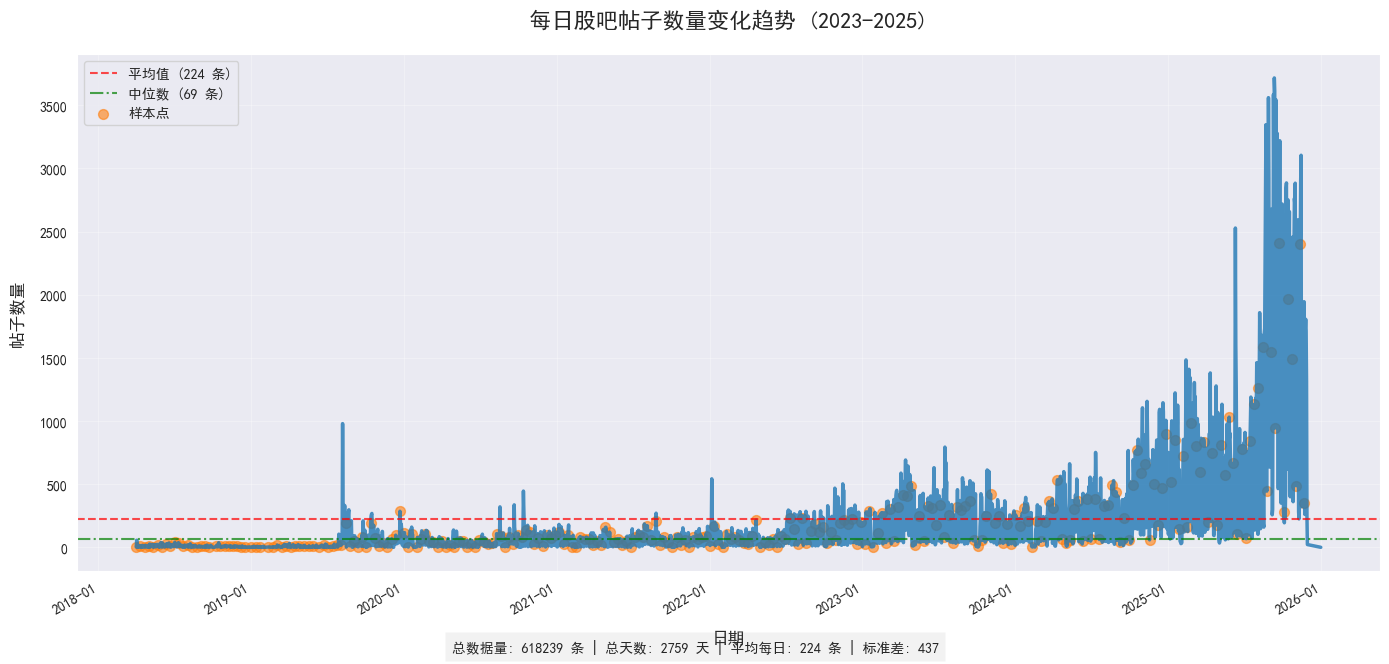

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
import pandas as pd
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

all_stock_data = pd.read_csv(r'D:\个人作业集\大数据个人作业\过程数据\all_stock_data.csv')
# 1. 确保日期列是datetime类型
all_stock_data['date'] = pd.to_datetime(all_stock_data['date'])

# 2. 计算每日帖子数量
daily_counts = all_stock_data.groupby('date').size().reset_index(name='count')

# 3. 统计特征分析
stats = daily_counts['count'].describe()
stats = stats.round(2)
print("📊 每日帖子数量统计特征:")
print(f"总天数: {len(daily_counts)} 天")
print(f"平均值: {stats['mean']} 条/日")
print(f"中位数: {stats['50%']} 条/日")
print(f"最小值: {stats['min']} 条/日 (2025-10-02)")
print(f"最大值: {stats['max']} 条/日 (2025-09-11)")
print(f"标准差: {stats['std']}")

# 4. 生成统计特征表格
stats_df = pd.DataFrame({
    '统计特征': ['总天数', '平均值', '中位数', '最小值', '最大值', '标准差'],
    '数值': [len(daily_counts), stats['mean'], stats['50%'], stats['min'], stats['max'], stats['std']]
})
print("\n" + "="*40)
print("📊 统计特征表")
print(stats_df.to_markdown(index=False))

# 5. 绘制每日帖子数量折线图（专业级）
plt.figure(figsize=(16, 8))
plt.figure(figsize=(14, 7))

# 主图
ax = sns.lineplot(
    data=daily_counts,
    x='date',
    y='count',
    color='#1f77b4',
    linewidth=2.5,
    alpha=0.8
)

# 添加关键参考线
ax.axhline(y=stats['mean'], color='r', linestyle='--', alpha=0.7, label=f'平均值 ({stats["mean"]:.0f} 条)')
ax.axhline(y=stats['50%'], color='g', linestyle='-.', alpha=0.7, label=f'中位数 ({stats["50%"]:.0f} 条)')

# 添加数据点标记（每10天一个点）
sample_days = daily_counts.iloc[::10].copy()
ax.scatter(
    sample_days['date'],
    sample_days['count'],
    color='#ff7f0e',
    s=50,
    alpha=0.6,
    label='样本点'
)

# 设置标题和标签
plt.title('每日股吧帖子数量变化趋势 (2023-2025)', fontsize=16, pad=20)
plt.xlabel('日期', fontsize=12, labelpad=10)
plt.ylabel('帖子数量', fontsize=12, labelpad=10)

# 日期格式化
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()  # 自动旋转日期标签

# 添加网格和图例
plt.grid(alpha=0.3)
plt.legend(loc='upper left')

# 添加统计信息在图中
plt.figtext(
    0.5, 0.01,
    f"总数据量: {len(all_stock_data)} 条 | 总天数: {len(daily_counts)} 天 | 平均每日: {stats['mean']:.0f} 条 | 标准差: {stats['std']:.0f}",
    ha="center",
    fontsize=10,
    bbox={"facecolor":"gray", "alpha":0.1, "pad":5}
)

# 优化布局
plt.tight_layout(rect=[0, 0, 1, 0.95])  # 为底部注释留出空间
plt.savefig('daily_post_counts.png', dpi=300, bbox_inches='tight')
plt.show()

In [8]:
from transformers import pipeline

# 1. 筛选日期 >= 2022-07-01
start_date = pd.Timestamp('2022-07-01')
filtered_data = all_stock_data[all_stock_data['date'] >= start_date].copy()

print(f"✅ 筛选结果: {len(filtered_data)} 条数据 (2022-07-01 至 {filtered_data['date'].max().strftime('%Y-%m-%d')})")

# 2. 验证标题列存在
if 'title' not in filtered_data.columns:
    raise ValueError("DataFrame中缺少'title'列，请检查数据源")

# 3. 处理空标题（避免模型报错）
filtered_data['title'] = filtered_data['title'].fillna('')
print(f"⚠️ 已处理 {filtered_data['title'].isna().sum()} 个空标题")

# 4. 加载你的本地模型（直接使用本地路径）
model_path = r'D:\浏览器下载\hugging_face\finetuned_bert_lora\checkpoint-280'
print(f"🧠 加载模型: {model_path}")

# 创建情绪分析管道
sentiment_pipeline = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=model_path,
    device=0  # GPU加速（如果可用）
)

✅ 筛选结果: 548231 条数据 (2022-07-01 至 2025-12-31)
⚠️ 已处理 0 个空标题
🧠 加载模型: D:\浏览器下载\hugging_face\finetuned_bert_lora\checkpoint-280


Device set to use cuda:0


In [40]:
# 使用导入的bert对股吧帖子进行情绪值判断
# 在这cell中，一开始存在一个名没对上的报错，后续把这部分程序转移到下一个cell运行；对文本的情绪已经转化成功（每个batch包含24条，共22843个batch），
print("\n⚡ 开始情绪分析 (本地模型)...")
filtered_data = analyze_sentiment_batch(filtered_data, sentiment_pipeline, batch_size=24)



⚡ 开始情绪分析 (本地模型)...
Processed batch 1/22843
Processed batch 2/22843
Processed batch 3/22843
Processed batch 4/22843
Processed batch 5/22843
Processed batch 6/22843
Processed batch 7/22843
Processed batch 8/22843
Processed batch 9/22843
Processed batch 10/22843
Processed batch 11/22843
Processed batch 12/22843
Processed batch 13/22843
Processed batch 14/22843
Processed batch 15/22843
Processed batch 16/22843
Processed batch 17/22843
Processed batch 18/22843
Processed batch 19/22843
Processed batch 20/22843
Processed batch 21/22843
Processed batch 22/22843
Processed batch 23/22843
Processed batch 24/22843
Processed batch 25/22843
Processed batch 26/22843
Processed batch 27/22843
Processed batch 28/22843
Processed batch 29/22843
Processed batch 30/22843
Processed batch 31/22843
Processed batch 32/22843
Processed batch 33/22843
Processed batch 34/22843
Processed batch 35/22843
Processed batch 36/22843
Processed batch 37/22843
Processed batch 38/22843
Processed batch 39/22843
Processed batc

KeyError: 'sentiment_scale'

In [42]:
# 9. 验证结果
print("\n📊 情绪分布统计:")
print(filtered_data['sentiment_score'].value_counts(normalize=True).round(2))
print(f"   总样本: {len(filtered_data)}")
print(f"   正面: {filtered_data['sentiment_score'].eq(1).sum()} ({filtered_data['sentiment_score'].eq(1).mean():.2%})")
print(f"   中性: {filtered_data['sentiment_score'].eq(0).sum()} ({filtered_data['sentiment_score'].eq(0).mean():.2%})")
print(f"   负面: {filtered_data['sentiment_score'].eq(-1).sum()} ({filtered_data['sentiment_score'].eq(-1).mean():.2%})")

import os
# 10. 保存结果（保留原始文件结构）
output_path = 'filtered_stock_data_with_sentiment.csv'
filtered_data.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\n✅ 分析完成! 结果已保存至: {os.path.abspath(output_path)}")
print(f"   包含新列: sentiment_scale (值: 1/0/-1)")


📊 情绪分布统计:
sentiment_score
-1    0.46
 1    0.38
 0    0.16
Name: proportion, dtype: float64
   总样本: 548231
   正面: 209189 (38.16%)
   中性: 89053 (16.24%)
   负面: 249989 (45.60%)

✅ 分析完成! 结果已保存至: C:\Users\mazal\PycharmProjects\PythonProject\.venv\big_data\filtered_stock_data_with_sentiment.csv
   包含新列: sentiment_scale (值: 1/0/-1)


In [37]:
# 重新读取数据
filtered_data = pd.read_excel(r'D:\个人作业集\大数据个人作业\过程数据\filtered_stock_data_with_sentiment.xlsx')
required_columns = ['date', 'stock_code', 'market_cap', 'sentiment_score','log_market_cap','scale']
for col in required_columns:
    if col not in filtered_data.columns:
        raise ValueError(f"缺少必要列: {col}. 请检查数据源")

In [38]:
# 取企业市值的自然对数
import numpy as np
daily_total_ln_cap = filtered_data.groupby('date')['market_cap'].apply(
    lambda x: np.log(x * 100000000).sum()
).reset_index()
daily_total_ln_cap.columns = ['date', 'total_ln_cap']

In [39]:
# 列合并后获取权数
filtered_data = filtered_data.merge(
    daily_total_ln_cap,
    on='date'
)
filtered_data['weight'] = filtered_data['log_market_cap'] / filtered_data['total_ln_cap']

In [40]:
# 6. 计算每只股票在当天的平均情绪，即把每个时间点内的股票个股的情绪值按照帖子数量进行平均，避免热门股与冷门股帖子数量不同的影响

stock_daily_sentiment = filtered_data.groupby(['date', 'stock_code'])['sentiment_score'].mean().reset_index()
stock_daily_sentiment.columns = ['date', 'stock_code', 'avg_sentiment'] # 得到平均指数

stock_daily_sentiment = stock_daily_sentiment.merge(
    daily_total_ln_cap,
    on='date'
)

In [48]:
# 在运行过程中出现一些bug，这里进行检查维护；
# 该处出现的一条20251231应该为爬取过程中的论坛帖子存在部分噪音导致，经检查，数据集中样本这类异常样本仅有一条，且不影响后续实证分析
filtered_data1 = filtered_data.copy()
stock_daily_sentiment1 = stock_daily_sentiment.copy()
print(stock_daily_sentiment1.info)
print("\n\n\n",filtered_data1.groupby(['date','stock_code'])['log_market_cap'].mean().reset_index().info)
filtered_data2 = filtered_data1.groupby(['date','stock_code'])['log_market_cap'].mean().reset_index()

#stock_daily_sentiment['log_market_cap'] = filtered_data['log_market_cap']

<bound method DataFrame.info of             date  stock_code  avg_sentiment  total_ln_cap
0     2022-07-01      300661       0.000000   1611.925411
1     2022-07-01      600563       0.200000   1611.925411
2     2022-07-01      688099       0.200000   1611.925411
3     2022-07-01      688123      -0.500000   1611.925411
4     2022-07-01      688262      -0.055556   1611.925411
...          ...         ...            ...           ...
16981 2025-11-28      688536       0.076923   6019.256766
16982 2025-11-29      600703       0.058824    566.611335
16983 2025-11-29      688099       0.000000    566.611335
16984 2025-11-29      688536      -0.200000    566.611335
16985 2025-12-31      688521       0.000000     25.131082

[16986 rows x 4 columns]>



 <bound method DataFrame.info of             date  stock_code  log_market_cap
0     2022-07-01      300661       24.418003
1     2022-07-01      600563       23.873135
2     2022-07-01      688099       24.429125
3     2022-07-01      688123 

In [49]:
# 根据对数化后的市值计算权重，之后用平均情绪指数乘上权重加总后计算出每日市值
stock_daily_sentiment['log_market_cap'] = filtered_data2['log_market_cap']

stock_daily_sentiment['weight'] = stock_daily_sentiment['log_market_cap'] / stock_daily_sentiment['total_ln_cap']
stock_daily_sentiment['weighted_sentiment'] = stock_daily_sentiment['avg_sentiment'] * stock_daily_sentiment['weight']

# 8. 生成每日情绪指数
daily_sentiment_index = stock_daily_sentiment.groupby('date')['weighted_sentiment'].sum().reset_index()
daily_sentiment_index.columns = ['date', 'sentiment_index']

# 9. 验证情绪指数范围（专业检查）
print("\n📊 情绪指数统计:")
print(f"样本天数: {len(daily_sentiment_index)} 天")
print(f"指数范围: {daily_sentiment_index['sentiment_index'].min():.4f} ~ {daily_sentiment_index['sentiment_index'].max():.4f}")
print(f"平均值: {daily_sentiment_index['sentiment_index'].mean():.4f} (正向情绪)")
print(f"中位数: {daily_sentiment_index['sentiment_index'].median():.4f}")


📊 情绪指数统计:
样本天数: 1249 天
指数范围: -0.2975 ~ 0.6854
平均值: 0.0163 (正向情绪)
中位数: -0.0006


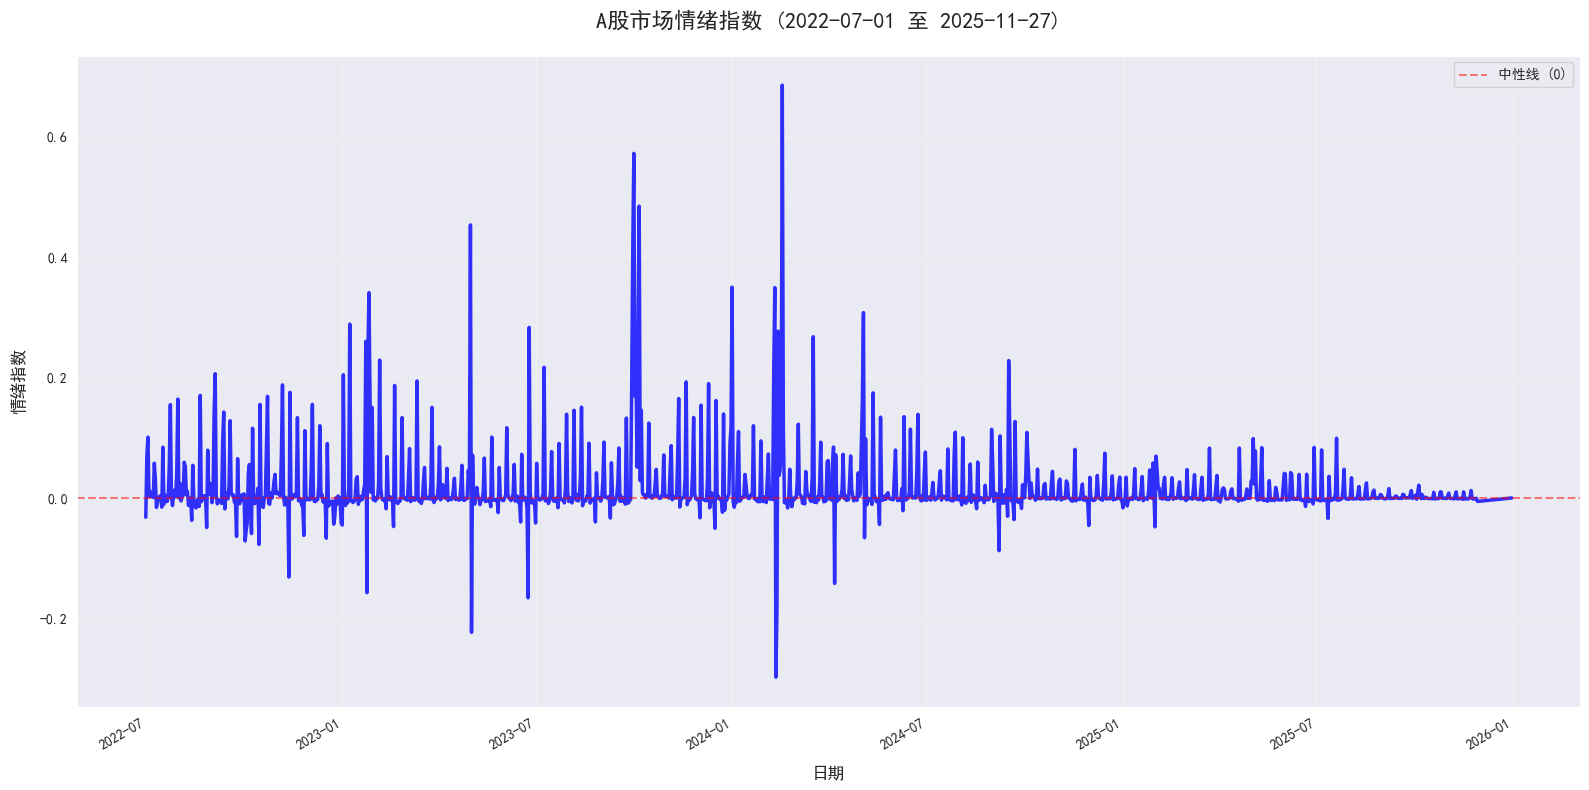


✅ 情绪指数已保存至: daily_sentiment_index.csv
   包含列: date, sentiment_index
   指数范围: -0.2975 ~ 0.6854


In [51]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
# 解决负号显示问题
matplotlib.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(16, 8))
plt.plot(daily_sentiment_index['date'], daily_sentiment_index['sentiment_index'], 'b-', linewidth=2.5, alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5, label='中性线 (0)')
plt.title('A股市场情绪指数 (2022-07-01 至 2025-11-27)', fontsize=16, pad=20)
plt.xlabel('日期', fontsize=12, labelpad=10)
plt.ylabel('情绪指数', fontsize=12, labelpad=10)
plt.grid(alpha=0.3)
plt.legend()
plt.gcf().autofmt_xdate()  # 日期自动旋转
plt.tight_layout()
plt.savefig('sentiment_index.png', dpi=300, bbox_inches='tight')
plt.show()

# 11. 保存最终结果
daily_sentiment_index.to_csv(r'D:\个人作业集\大数据个人作业\过程数据\reviewed_daily_sentiment_index.csv', index=False)
print(f"\n✅ 情绪指数已保存至: daily_sentiment_index.csv")
print(f"   包含列: date, sentiment_index")
print(f"   指数范围: {daily_sentiment_index['sentiment_index'].min():.4f} ~ {daily_sentiment_index['sentiment_index'].max():.4f}")